In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, # GQN
                                                                   labels=next_states_labels))
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                  action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
#     ###################################################### Q(s,a)= r + Q'(s',a')
#     targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
#     eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
#     eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
#     aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
#     eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
#     aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:17.0000 R:17.0000 rate:0.0340 aloss:0.6873 eloss:1.6240 aloss2:1.3295 exploreP:0.9983
Episode:1 meanR:25.5000 R:34.0000 rate:0.0680 aloss:0.6814 eloss:1.6228 aloss2:1.3219 exploreP:0.9950
Episode:2 meanR:21.0000 R:12.0000 rate:0.0240 aloss:0.6761 eloss:1.6321 aloss2:1.3153 exploreP:0.9938
Episode:3 meanR:22.7500 R:28.0000 rate:0.0560 aloss:0.6788 eloss:1.6086 aloss2:1.3190 exploreP:0.9910
Episode:4 meanR:21.0000 R:14.0000 rate:0.0280 aloss:0.6783 eloss:1.5903 aloss2:1.3269 exploreP:0.9897
Episode:5 meanR:25.6667 R:49.0000 rate:0.0980 aloss:0.6909 eloss:1.5630 aloss2:1.3353 exploreP:0.9849
Episode:6 meanR:24.5714 R:18.0000 rate:0.0360 aloss:0.6841 eloss:1.5216 aloss2:1.3527 exploreP:0.9831
Episode:7 meanR:23.8750 R:19.0000 rate:0.0380 aloss:0.7112 eloss:1.4892 aloss2:1.3641 exploreP:0.9813
Episode:8 meanR:22.8889 R:15.0000 rate:0.0300 aloss:0.6789 eloss:1.5179 aloss2:1.3564 exploreP:0.9798
Episode:9 meanR:24.8000 R:42.0000 rate:0.0840 aloss:0.6875 eloss:1.4731 aloss2:1.3

Episode:80 meanR:24.0617 R:16.0000 rate:0.0320 aloss:0.6922 eloss:0.7965 aloss2:1.9710 exploreP:0.8247
Episode:81 meanR:23.9268 R:13.0000 rate:0.0260 aloss:0.6955 eloss:0.7983 aloss2:1.9635 exploreP:0.8236
Episode:82 meanR:23.7711 R:11.0000 rate:0.0220 aloss:0.7166 eloss:0.8249 aloss2:1.9624 exploreP:0.8227
Episode:83 meanR:23.6548 R:14.0000 rate:0.0280 aloss:0.7024 eloss:0.7993 aloss2:1.9858 exploreP:0.8216
Episode:84 meanR:23.5294 R:13.0000 rate:0.0260 aloss:0.6959 eloss:0.7849 aloss2:1.9943 exploreP:0.8205
Episode:85 meanR:23.6977 R:38.0000 rate:0.0760 aloss:0.7054 eloss:0.7951 aloss2:1.9828 exploreP:0.8175
Episode:86 meanR:23.9425 R:45.0000 rate:0.0900 aloss:0.7014 eloss:0.7838 aloss2:2.0179 exploreP:0.8138
Episode:87 meanR:23.8182 R:13.0000 rate:0.0260 aloss:0.7049 eloss:0.7856 aloss2:2.0144 exploreP:0.8128
Episode:88 meanR:23.7191 R:15.0000 rate:0.0300 aloss:0.6912 eloss:0.7633 aloss2:2.0461 exploreP:0.8116
Episode:89 meanR:23.6111 R:14.0000 rate:0.0280 aloss:0.6958 eloss:0.7693 

Episode:159 meanR:40.7500 R:110.0000 rate:0.2200 aloss:0.6944 eloss:0.5206 aloss2:3.2866 exploreP:0.5787
Episode:160 meanR:41.1300 R:56.0000 rate:0.1120 aloss:0.6937 eloss:0.4941 aloss2:3.2812 exploreP:0.5755
Episode:161 meanR:41.4000 R:48.0000 rate:0.0960 aloss:0.6893 eloss:0.5292 aloss2:3.2832 exploreP:0.5728
Episode:162 meanR:41.1900 R:37.0000 rate:0.0740 aloss:0.6983 eloss:0.5259 aloss2:3.2962 exploreP:0.5707
Episode:163 meanR:41.1900 R:21.0000 rate:0.0420 aloss:0.7087 eloss:0.5581 aloss2:3.2503 exploreP:0.5695
Episode:164 meanR:41.7000 R:73.0000 rate:0.1460 aloss:0.7004 eloss:0.4957 aloss2:3.2869 exploreP:0.5655
Episode:165 meanR:42.6100 R:113.0000 rate:0.2260 aloss:0.7140 eloss:0.5028 aloss2:3.3051 exploreP:0.5592
Episode:166 meanR:43.3600 R:84.0000 rate:0.1680 aloss:0.7098 eloss:0.5145 aloss2:3.3285 exploreP:0.5546
Episode:167 meanR:44.3200 R:112.0000 rate:0.2240 aloss:0.7154 eloss:0.5034 aloss2:3.3209 exploreP:0.5486
Episode:168 meanR:45.1700 R:105.0000 rate:0.2100 aloss:0.7361

Episode:238 meanR:93.3400 R:207.0000 rate:0.4140 aloss:0.6682 eloss:0.5794 aloss2:3.4854 exploreP:0.2802
Episode:239 meanR:94.2600 R:120.0000 rate:0.2400 aloss:0.6702 eloss:0.5350 aloss2:3.4725 exploreP:0.2770
Episode:240 meanR:94.1200 R:141.0000 rate:0.2820 aloss:0.6683 eloss:0.5872 aloss2:3.4651 exploreP:0.2733
Episode:241 meanR:94.1100 R:153.0000 rate:0.3060 aloss:0.6660 eloss:0.5685 aloss2:3.4632 exploreP:0.2693
Episode:242 meanR:95.9100 R:210.0000 rate:0.4200 aloss:0.6674 eloss:0.5761 aloss2:3.4552 exploreP:0.2639
Episode:243 meanR:97.1300 R:139.0000 rate:0.2780 aloss:0.6659 eloss:0.5706 aloss2:3.4542 exploreP:0.2604
Episode:244 meanR:96.1400 R:118.0000 rate:0.2360 aloss:0.6703 eloss:0.5725 aloss2:3.4500 exploreP:0.2574
Episode:245 meanR:97.2200 R:188.0000 rate:0.3760 aloss:0.6653 eloss:0.5940 aloss2:3.4335 exploreP:0.2528
Episode:246 meanR:97.8800 R:192.0000 rate:0.3840 aloss:0.6681 eloss:0.5812 aloss2:3.4214 exploreP:0.2482
Episode:247 meanR:97.9400 R:106.0000 rate:0.2120 aloss:

Episode:316 meanR:121.9700 R:101.0000 rate:0.2020 aloss:0.6629 eloss:0.6118 aloss2:3.3332 exploreP:0.1128
Episode:317 meanR:121.4500 R:140.0000 rate:0.2800 aloss:0.6646 eloss:0.6265 aloss2:3.3206 exploreP:0.1114
Episode:318 meanR:121.5600 R:75.0000 rate:0.1500 aloss:0.6611 eloss:0.6512 aloss2:3.3027 exploreP:0.1106
Episode:319 meanR:121.8600 R:115.0000 rate:0.2300 aloss:0.6656 eloss:0.6059 aloss2:3.2980 exploreP:0.1095
Episode:320 meanR:121.8500 R:129.0000 rate:0.2580 aloss:0.6643 eloss:0.5901 aloss2:3.3059 exploreP:0.1082
Episode:321 meanR:122.4400 R:117.0000 rate:0.2340 aloss:0.6646 eloss:0.5931 aloss2:3.3106 exploreP:0.1071
Episode:322 meanR:121.2700 R:111.0000 rate:0.2220 aloss:0.6658 eloss:0.5737 aloss2:3.3104 exploreP:0.1060
Episode:323 meanR:122.1000 R:152.0000 rate:0.3040 aloss:0.6648 eloss:0.5978 aloss2:3.3248 exploreP:0.1045
Episode:324 meanR:122.9100 R:144.0000 rate:0.2880 aloss:0.6693 eloss:0.6390 aloss2:3.2994 exploreP:0.1032
Episode:325 meanR:123.6400 R:104.0000 rate:0.20

Episode:394 meanR:110.2100 R:105.0000 rate:0.2100 aloss:0.7562 eloss:0.6510 aloss2:3.1092 exploreP:0.0563
Episode:395 meanR:111.6900 R:314.0000 rate:0.6280 aloss:0.7269 eloss:0.6989 aloss2:3.1110 exploreP:0.0549
Episode:396 meanR:112.2300 R:175.0000 rate:0.3500 aloss:0.7520 eloss:0.6260 aloss2:3.0922 exploreP:0.0541
Episode:397 meanR:114.5000 R:383.0000 rate:0.7660 aloss:0.7457 eloss:0.6370 aloss2:3.1185 exploreP:0.0524
Episode:398 meanR:114.8100 R:144.0000 rate:0.2880 aloss:0.7532 eloss:0.6251 aloss2:3.1362 exploreP:0.0518
Episode:399 meanR:114.1400 R:110.0000 rate:0.2200 aloss:0.7359 eloss:0.6674 aloss2:3.1527 exploreP:0.0514
Episode:400 meanR:113.9700 R:115.0000 rate:0.2300 aloss:0.7383 eloss:0.7112 aloss2:3.1310 exploreP:0.0509
Episode:401 meanR:113.8900 R:137.0000 rate:0.2740 aloss:0.7524 eloss:0.6415 aloss2:3.1116 exploreP:0.0504
Episode:402 meanR:117.1700 R:484.0000 rate:0.9680 aloss:0.7329 eloss:0.6734 aloss2:3.1142 exploreP:0.0484
Episode:403 meanR:116.3400 R:137.0000 rate:0.2

Episode:472 meanR:134.8500 R:56.0000 rate:0.1120 aloss:0.7385 eloss:0.6678 aloss2:3.0372 exploreP:0.0272
Episode:473 meanR:134.9000 R:105.0000 rate:0.2100 aloss:0.7548 eloss:0.7615 aloss2:3.0106 exploreP:0.0271
Episode:474 meanR:135.6500 R:201.0000 rate:0.4020 aloss:0.7268 eloss:0.7126 aloss2:3.0185 exploreP:0.0267
Episode:475 meanR:135.8600 R:137.0000 rate:0.2740 aloss:0.7179 eloss:0.7599 aloss2:2.9961 exploreP:0.0265
Episode:476 meanR:134.9400 R:32.0000 rate:0.0640 aloss:0.6948 eloss:0.7827 aloss2:2.9899 exploreP:0.0264
Episode:477 meanR:135.0000 R:123.0000 rate:0.2460 aloss:0.7431 eloss:0.6994 aloss2:2.9909 exploreP:0.0262
Episode:478 meanR:135.4800 R:157.0000 rate:0.3140 aloss:0.7194 eloss:0.7153 aloss2:2.9855 exploreP:0.0260
Episode:479 meanR:135.4900 R:120.0000 rate:0.2400 aloss:0.7416 eloss:0.6594 aloss2:3.0061 exploreP:0.0258
Episode:480 meanR:136.0300 R:166.0000 rate:0.3320 aloss:0.7631 eloss:0.6992 aloss2:3.0207 exploreP:0.0255
Episode:481 meanR:139.6400 R:500.0000 rate:1.000

Episode:550 meanR:203.7600 R:52.0000 rate:0.1040 aloss:0.6422 eloss:0.8581 aloss2:3.1643 exploreP:0.0127
Episode:551 meanR:206.5500 R:415.0000 rate:0.8300 aloss:0.6692 eloss:0.8633 aloss2:3.1757 exploreP:0.0126
Episode:552 meanR:206.5100 R:99.0000 rate:0.1980 aloss:0.6449 eloss:0.9820 aloss2:3.1482 exploreP:0.0126
Episode:553 meanR:209.9500 R:397.0000 rate:0.7940 aloss:0.6683 eloss:0.8717 aloss2:3.1665 exploreP:0.0125
Episode:554 meanR:209.9200 R:90.0000 rate:0.1800 aloss:0.6575 eloss:0.9310 aloss2:3.1774 exploreP:0.0125
Episode:555 meanR:212.7100 R:458.0000 rate:0.9160 aloss:0.6545 eloss:0.9076 aloss2:3.1729 exploreP:0.0124
Episode:556 meanR:216.2200 R:400.0000 rate:0.8000 aloss:0.6486 eloss:0.9047 aloss2:3.1386 exploreP:0.0123
Episode:557 meanR:216.5600 R:82.0000 rate:0.1640 aloss:0.6582 eloss:0.8517 aloss2:3.1616 exploreP:0.0122
Episode:558 meanR:216.2900 R:133.0000 rate:0.2660 aloss:0.6606 eloss:0.8925 aloss2:3.1934 exploreP:0.0122
Episode:559 meanR:216.4800 R:87.0000 rate:0.1740 a

Episode:628 meanR:210.6100 R:83.0000 rate:0.1660 aloss:0.6235 eloss:0.9757 aloss2:3.0890 exploreP:0.0105
Episode:629 meanR:212.0000 R:262.0000 rate:0.5240 aloss:0.5475 eloss:1.0241 aloss2:3.1030 exploreP:0.0105
Episode:630 meanR:210.2200 R:163.0000 rate:0.3260 aloss:0.5606 eloss:1.0602 aloss2:3.0999 exploreP:0.0105
Episode:631 meanR:209.9700 R:126.0000 rate:0.2520 aloss:0.5841 eloss:1.0825 aloss2:3.0861 exploreP:0.0105
Episode:632 meanR:211.6200 R:266.0000 rate:0.5320 aloss:0.5838 eloss:1.0417 aloss2:3.0916 exploreP:0.0105
Episode:633 meanR:213.0500 R:279.0000 rate:0.5580 aloss:0.5608 eloss:1.0548 aloss2:3.1032 exploreP:0.0105
Episode:634 meanR:214.4400 R:355.0000 rate:0.7100 aloss:0.5809 eloss:1.0973 aloss2:3.0575 exploreP:0.0104
Episode:635 meanR:214.3500 R:119.0000 rate:0.2380 aloss:0.6017 eloss:1.0689 aloss2:3.0800 exploreP:0.0104
Episode:636 meanR:214.0700 R:49.0000 rate:0.0980 aloss:0.5614 eloss:1.1337 aloss2:3.0896 exploreP:0.0104
Episode:637 meanR:212.4100 R:74.0000 rate:0.1480

Episode:706 meanR:249.4500 R:366.0000 rate:0.7320 aloss:0.4926 eloss:1.1718 aloss2:2.6872 exploreP:0.0101
Episode:707 meanR:248.8800 R:88.0000 rate:0.1760 aloss:0.4901 eloss:1.2073 aloss2:2.6570 exploreP:0.0101
Episode:708 meanR:245.0800 R:120.0000 rate:0.2400 aloss:0.5222 eloss:1.1593 aloss2:2.6809 exploreP:0.0101
Episode:709 meanR:246.8600 R:500.0000 rate:1.0000 aloss:0.4710 eloss:1.1562 aloss2:2.6942 exploreP:0.0101
Episode:710 meanR:246.6800 R:146.0000 rate:0.2920 aloss:0.4739 eloss:1.1752 aloss2:2.6655 exploreP:0.0101
Episode:711 meanR:250.3300 R:500.0000 rate:1.0000 aloss:0.4877 eloss:1.1913 aloss2:2.6676 exploreP:0.0101
Episode:712 meanR:250.3300 R:500.0000 rate:1.0000 aloss:0.4672 eloss:1.1722 aloss2:2.6658 exploreP:0.0101
Episode:713 meanR:252.6300 R:500.0000 rate:1.0000 aloss:0.4754 eloss:1.1863 aloss2:2.6527 exploreP:0.0101
Episode:714 meanR:252.1800 R:135.0000 rate:0.2700 aloss:0.4483 eloss:1.1722 aloss2:2.6399 exploreP:0.0101
Episode:715 meanR:253.9800 R:500.0000 rate:1.00

Episode:784 meanR:392.8500 R:377.0000 rate:0.7540 aloss:0.4207 eloss:0.9792 aloss2:3.1259 exploreP:0.0100
Episode:785 meanR:396.2000 R:500.0000 rate:1.0000 aloss:0.4132 eloss:0.9741 aloss2:3.1469 exploreP:0.0100
Episode:786 meanR:392.1900 R:99.0000 rate:0.1980 aloss:0.4199 eloss:0.9727 aloss2:3.1914 exploreP:0.0100
Episode:787 meanR:396.1800 R:500.0000 rate:1.0000 aloss:0.4184 eloss:0.9667 aloss2:3.1953 exploreP:0.0100
Episode:788 meanR:396.1800 R:500.0000 rate:1.0000 aloss:0.4116 eloss:0.9645 aloss2:3.2042 exploreP:0.0100
Episode:789 meanR:392.2900 R:111.0000 rate:0.2220 aloss:0.4106 eloss:0.8873 aloss2:3.4927 exploreP:0.0100
Episode:790 meanR:396.4800 R:500.0000 rate:1.0000 aloss:0.4060 eloss:0.8940 aloss2:3.3040 exploreP:0.0100
Episode:791 meanR:396.7000 R:121.0000 rate:0.2420 aloss:0.3899 eloss:0.8392 aloss2:3.3997 exploreP:0.0100
Episode:792 meanR:398.6300 R:341.0000 rate:0.6820 aloss:0.4039 eloss:0.8536 aloss2:3.4636 exploreP:0.0100
Episode:793 meanR:398.6300 R:500.0000 rate:1.00

Episode:862 meanR:321.6600 R:103.0000 rate:0.2060 aloss:0.4492 eloss:0.9654 aloss2:3.6520 exploreP:0.0100
Episode:863 meanR:321.6600 R:500.0000 rate:1.0000 aloss:0.4537 eloss:1.0298 aloss2:3.7307 exploreP:0.0100
Episode:864 meanR:321.6600 R:500.0000 rate:1.0000 aloss:0.4426 eloss:0.9375 aloss2:3.6622 exploreP:0.0100
Episode:865 meanR:319.7500 R:309.0000 rate:0.6180 aloss:0.4513 eloss:0.9692 aloss2:3.6696 exploreP:0.0100
Episode:866 meanR:319.7500 R:500.0000 rate:1.0000 aloss:0.4419 eloss:0.9463 aloss2:3.6082 exploreP:0.0100
Episode:867 meanR:315.7400 R:99.0000 rate:0.1980 aloss:0.4414 eloss:0.8531 aloss2:3.8062 exploreP:0.0100
Episode:868 meanR:311.3300 R:59.0000 rate:0.1180 aloss:0.4312 eloss:0.8953 aloss2:3.7539 exploreP:0.0100
Episode:869 meanR:311.3300 R:500.0000 rate:1.0000 aloss:0.4464 eloss:0.9243 aloss2:3.7615 exploreP:0.0100
Episode:870 meanR:311.3300 R:500.0000 rate:1.0000 aloss:0.4397 eloss:0.9122 aloss2:3.7229 exploreP:0.0100
Episode:871 meanR:311.3200 R:75.0000 rate:0.1500

Episode:940 meanR:241.3100 R:39.0000 rate:0.0780 aloss:0.4275 eloss:0.9021 aloss2:4.6748 exploreP:0.0100
Episode:941 meanR:237.1800 R:87.0000 rate:0.1740 aloss:0.4205 eloss:0.8773 aloss2:4.8279 exploreP:0.0100
Episode:942 meanR:235.6400 R:346.0000 rate:0.6920 aloss:0.4224 eloss:0.9027 aloss2:4.7584 exploreP:0.0100
Episode:943 meanR:234.3400 R:13.0000 rate:0.0260 aloss:0.4156 eloss:0.8273 aloss2:4.8440 exploreP:0.0100
Episode:944 meanR:233.3100 R:127.0000 rate:0.2540 aloss:0.4259 eloss:0.9087 aloss2:4.7417 exploreP:0.0100
Episode:945 meanR:233.3100 R:500.0000 rate:1.0000 aloss:0.4244 eloss:0.8982 aloss2:4.8238 exploreP:0.0100
Episode:946 meanR:232.5600 R:152.0000 rate:0.3040 aloss:0.4231 eloss:0.8921 aloss2:4.8030 exploreP:0.0100
Episode:947 meanR:233.0400 R:99.0000 rate:0.1980 aloss:0.4229 eloss:0.8851 aloss2:4.8559 exploreP:0.0100
Episode:948 meanR:230.4100 R:98.0000 rate:0.1960 aloss:0.4271 eloss:0.8878 aloss2:4.8428 exploreP:0.0100
Episode:949 meanR:226.2700 R:86.0000 rate:0.1720 al

Episode:1018 meanR:218.7200 R:27.0000 rate:0.0540 aloss:0.4000 eloss:0.6618 aloss2:5.9858 exploreP:0.0100
Episode:1019 meanR:219.5700 R:500.0000 rate:1.0000 aloss:0.3977 eloss:0.7190 aloss2:5.8816 exploreP:0.0100
Episode:1020 meanR:222.0600 R:414.0000 rate:0.8280 aloss:0.3953 eloss:0.6844 aloss2:5.9842 exploreP:0.0100
Episode:1021 meanR:220.4000 R:334.0000 rate:0.6680 aloss:0.3954 eloss:0.6478 aloss2:6.0065 exploreP:0.0100
Episode:1022 meanR:219.2400 R:43.0000 rate:0.0860 aloss:0.3915 eloss:0.6379 aloss2:6.0065 exploreP:0.0100
Episode:1023 meanR:216.3300 R:10.0000 rate:0.0200 aloss:0.4139 eloss:0.8040 aloss2:5.8868 exploreP:0.0100
Episode:1024 meanR:216.1800 R:47.0000 rate:0.0940 aloss:0.3971 eloss:0.6054 aloss2:6.1493 exploreP:0.0100
Episode:1025 meanR:211.9200 R:11.0000 rate:0.0220 aloss:0.3905 eloss:0.4861 aloss2:6.4062 exploreP:0.0100
Episode:1026 meanR:212.8300 R:408.0000 rate:0.8160 aloss:0.3929 eloss:0.6391 aloss2:6.0556 exploreP:0.0100
Episode:1027 meanR:211.7600 R:10.0000 rate

Episode:1095 meanR:170.4800 R:45.0000 rate:0.0900 aloss:0.3740 eloss:0.5061 aloss2:6.9700 exploreP:0.0100
Episode:1096 meanR:169.8000 R:25.0000 rate:0.0500 aloss:0.3791 eloss:0.5928 aloss2:6.8113 exploreP:0.0100
Episode:1097 meanR:165.4100 R:61.0000 rate:0.1220 aloss:0.3720 eloss:0.5141 aloss2:6.9873 exploreP:0.0100
Episode:1098 meanR:162.5600 R:30.0000 rate:0.0600 aloss:0.3730 eloss:0.4777 aloss2:7.0249 exploreP:0.0100
Episode:1099 meanR:163.0500 R:60.0000 rate:0.1200 aloss:0.3746 eloss:0.4717 aloss2:7.1077 exploreP:0.0100
Episode:1100 meanR:162.6600 R:10.0000 rate:0.0200 aloss:0.3741 eloss:0.5385 aloss2:6.9853 exploreP:0.0100
Episode:1101 meanR:162.7400 R:45.0000 rate:0.0900 aloss:0.3767 eloss:0.4605 aloss2:7.1852 exploreP:0.0100
Episode:1102 meanR:162.8700 R:23.0000 rate:0.0460 aloss:0.3774 eloss:0.4803 aloss2:7.1424 exploreP:0.0100
Episode:1103 meanR:160.5100 R:55.0000 rate:0.1100 aloss:0.3713 eloss:0.5577 aloss2:6.9607 exploreP:0.0100
Episode:1104 meanR:158.1000 R:23.0000 rate:0.0

Episode:1173 meanR:109.3000 R:100.0000 rate:0.2000 aloss:0.3728 eloss:0.4279 aloss2:7.8015 exploreP:0.0100
Episode:1174 meanR:109.1500 R:62.0000 rate:0.1240 aloss:0.3695 eloss:0.4613 aloss2:7.7529 exploreP:0.0100
Episode:1175 meanR:111.9300 R:319.0000 rate:0.6380 aloss:0.3766 eloss:0.3740 aloss2:7.9146 exploreP:0.0100
Episode:1176 meanR:112.0500 R:22.0000 rate:0.0440 aloss:0.3717 eloss:0.4829 aloss2:7.7274 exploreP:0.0100
Episode:1177 meanR:107.2500 R:20.0000 rate:0.0400 aloss:0.3672 eloss:0.4643 aloss2:7.8008 exploreP:0.0100
Episode:1178 meanR:106.1900 R:11.0000 rate:0.0220 aloss:0.3675 eloss:0.5598 aloss2:7.6408 exploreP:0.0100
Episode:1179 meanR:106.2800 R:19.0000 rate:0.0380 aloss:0.3723 eloss:0.5254 aloss2:7.7025 exploreP:0.0100
Episode:1180 meanR:111.1800 R:500.0000 rate:1.0000 aloss:0.3716 eloss:0.3450 aloss2:7.9451 exploreP:0.0100
Episode:1181 meanR:111.3000 R:22.0000 rate:0.0440 aloss:0.3734 eloss:0.3779 aloss2:7.9680 exploreP:0.0100
Episode:1182 meanR:111.3000 R:500.0000 rate

Episode:1251 meanR:123.5100 R:10.0000 rate:0.0200 aloss:0.3800 eloss:0.1922 aloss2:9.0974 exploreP:0.0100
Episode:1252 meanR:122.9700 R:128.0000 rate:0.2560 aloss:0.3674 eloss:0.1465 aloss2:9.0540 exploreP:0.0100
Episode:1253 meanR:121.5500 R:212.0000 rate:0.4240 aloss:0.3663 eloss:0.2742 aloss2:8.8626 exploreP:0.0100
Episode:1254 meanR:122.5200 R:342.0000 rate:0.6840 aloss:0.3672 eloss:0.2977 aloss2:8.8679 exploreP:0.0100
Episode:1255 meanR:122.5000 R:22.0000 rate:0.0440 aloss:0.3816 eloss:0.3664 aloss2:8.9070 exploreP:0.0100
Episode:1256 meanR:122.6000 R:21.0000 rate:0.0420 aloss:0.3719 eloss:0.1290 aloss2:9.2019 exploreP:0.0100
Episode:1257 meanR:122.1900 R:23.0000 rate:0.0460 aloss:0.3656 eloss:0.3146 aloss2:8.8536 exploreP:0.0100
Episode:1258 meanR:119.0400 R:22.0000 rate:0.0440 aloss:0.3658 eloss:0.2259 aloss2:9.0230 exploreP:0.0100
Episode:1259 meanR:120.7900 R:197.0000 rate:0.3940 aloss:0.3666 eloss:0.2663 aloss2:8.9634 exploreP:0.0100
Episode:1260 meanR:120.8000 R:23.0000 rate

Episode:1328 meanR:153.2100 R:16.0000 rate:0.0320 aloss:0.3589 eloss:0.1176 aloss2:10.1919 exploreP:0.0100
Episode:1329 meanR:153.5600 R:500.0000 rate:1.0000 aloss:0.3574 eloss:0.0618 aloss2:10.3300 exploreP:0.0100
Episode:1330 meanR:153.5700 R:22.0000 rate:0.0440 aloss:0.3530 eloss:-0.0842 aloss2:10.4448 exploreP:0.0100
Episode:1331 meanR:156.6400 R:500.0000 rate:1.0000 aloss:0.3570 eloss:0.0453 aloss2:10.4114 exploreP:0.0100
Episode:1332 meanR:156.4600 R:10.0000 rate:0.0200 aloss:0.3617 eloss:0.1690 aloss2:10.2947 exploreP:0.0100
Episode:1333 meanR:157.7700 R:142.0000 rate:0.2840 aloss:0.3569 eloss:0.0278 aloss2:10.4654 exploreP:0.0100
Episode:1334 meanR:157.8000 R:13.0000 rate:0.0260 aloss:0.3573 eloss:0.1863 aloss2:10.3680 exploreP:0.0100
Episode:1335 meanR:160.7800 R:500.0000 rate:1.0000 aloss:0.3574 eloss:-0.0040 aloss2:10.5694 exploreP:0.0100
Episode:1336 meanR:162.5000 R:182.0000 rate:0.3640 aloss:0.3551 eloss:-0.0516 aloss2:10.6824 exploreP:0.0100
Episode:1337 meanR:162.5000 R

Episode:1404 meanR:151.6200 R:289.0000 rate:0.5780 aloss:0.3496 eloss:-0.3053 aloss2:12.2253 exploreP:0.0100
Episode:1405 meanR:156.2300 R:472.0000 rate:0.9440 aloss:0.3501 eloss:-0.3688 aloss2:12.4024 exploreP:0.0100
Episode:1406 meanR:157.1900 R:106.0000 rate:0.2120 aloss:0.3523 eloss:-0.2059 aloss2:12.1828 exploreP:0.0100
Episode:1407 meanR:157.1900 R:500.0000 rate:1.0000 aloss:0.3495 eloss:-0.3668 aloss2:12.4682 exploreP:0.0100
Episode:1408 meanR:161.9300 R:500.0000 rate:1.0000 aloss:0.3511 eloss:-0.3767 aloss2:12.5289 exploreP:0.0100
Episode:1409 meanR:164.6600 R:283.0000 rate:0.5660 aloss:0.3492 eloss:-0.4040 aloss2:12.6089 exploreP:0.0100
Episode:1410 meanR:161.8800 R:22.0000 rate:0.0440 aloss:0.3503 eloss:-0.4524 aloss2:12.6079 exploreP:0.0100
Episode:1411 meanR:161.0800 R:420.0000 rate:0.8400 aloss:0.3484 eloss:-0.4418 aloss2:12.7316 exploreP:0.0100
Episode:1412 meanR:160.9900 R:453.0000 rate:0.9060 aloss:0.3495 eloss:-0.5090 aloss2:12.9001 exploreP:0.0100
Episode:1413 meanR:1

Episode:1480 meanR:235.7100 R:12.0000 rate:0.0240 aloss:0.3498 eloss:-0.7280 aloss2:16.2223 exploreP:0.0100
Episode:1481 meanR:237.2700 R:500.0000 rate:1.0000 aloss:0.3440 eloss:-1.3295 aloss2:17.1217 exploreP:0.0100
Episode:1482 meanR:237.3100 R:19.0000 rate:0.0380 aloss:0.3544 eloss:-1.1460 aloss2:16.7663 exploreP:0.0100
Episode:1483 meanR:240.1100 R:500.0000 rate:1.0000 aloss:0.3476 eloss:-1.1398 aloss2:16.9363 exploreP:0.0100
Episode:1484 meanR:240.9800 R:115.0000 rate:0.2300 aloss:0.3466 eloss:-1.3178 aloss2:17.3373 exploreP:0.0100
Episode:1485 meanR:245.7600 R:500.0000 rate:1.0000 aloss:0.3451 eloss:-1.1029 aloss2:16.9591 exploreP:0.0100
Episode:1486 meanR:245.7000 R:16.0000 rate:0.0320 aloss:0.3470 eloss:-1.2225 aloss2:17.2486 exploreP:0.0100
Episode:1487 meanR:250.4700 R:500.0000 rate:1.0000 aloss:0.3485 eloss:-1.1376 aloss2:17.1398 exploreP:0.0100
Episode:1488 meanR:250.3200 R:11.0000 rate:0.0220 aloss:0.3459 eloss:-1.0758 aloss2:16.9976 exploreP:0.0100
Episode:1489 meanR:245.

Episode:1556 meanR:238.4900 R:500.0000 rate:1.0000 aloss:0.3544 eloss:-1.3330 aloss2:20.0793 exploreP:0.0100
Episode:1557 meanR:242.0800 R:500.0000 rate:1.0000 aloss:0.3532 eloss:-1.2798 aloss2:20.0452 exploreP:0.0100
Episode:1558 meanR:246.8700 R:500.0000 rate:1.0000 aloss:0.3551 eloss:-1.1983 aloss2:20.0637 exploreP:0.0100
Episode:1559 meanR:249.6800 R:500.0000 rate:1.0000 aloss:0.3554 eloss:-1.2150 aloss2:20.1831 exploreP:0.0100
Episode:1560 meanR:251.9500 R:350.0000 rate:0.7000 aloss:0.3600 eloss:-1.2529 aloss2:20.2947 exploreP:0.0100
Episode:1561 meanR:256.7700 R:500.0000 rate:1.0000 aloss:0.3591 eloss:-1.0701 aloss2:20.1318 exploreP:0.0100
Episode:1562 meanR:256.7700 R:500.0000 rate:1.0000 aloss:0.3597 eloss:-1.0605 aloss2:20.1629 exploreP:0.0100
Episode:1563 meanR:255.5300 R:14.0000 rate:0.0280 aloss:0.3546 eloss:-0.9555 aloss2:19.9313 exploreP:0.0100
Episode:1564 meanR:255.5300 R:500.0000 rate:1.0000 aloss:0.3543 eloss:-1.1976 aloss2:20.3982 exploreP:0.0100
Episode:1565 meanR:2

Episode:1632 meanR:365.3200 R:500.0000 rate:1.0000 aloss:0.3530 eloss:-1.8112 aloss2:24.6130 exploreP:0.0100
Episode:1633 meanR:366.0200 R:149.0000 rate:0.2980 aloss:0.3531 eloss:-1.8763 aloss2:24.7578 exploreP:0.0100
Episode:1634 meanR:370.8000 R:500.0000 rate:1.0000 aloss:0.3531 eloss:-1.8596 aloss2:24.7934 exploreP:0.0100
Episode:1635 meanR:375.5900 R:500.0000 rate:1.0000 aloss:0.3542 eloss:-1.8006 aloss2:24.7645 exploreP:0.0100
Episode:1636 meanR:375.5900 R:500.0000 rate:1.0000 aloss:0.3536 eloss:-1.8320 aloss2:24.9177 exploreP:0.0100
Episode:1637 meanR:375.2500 R:466.0000 rate:0.9320 aloss:0.3541 eloss:-1.9194 aloss2:25.0964 exploreP:0.0100
Episode:1638 meanR:372.1800 R:14.0000 rate:0.0280 aloss:0.3580 eloss:-1.4831 aloss2:24.8251 exploreP:0.0100
Episode:1639 meanR:376.9400 R:500.0000 rate:1.0000 aloss:0.3539 eloss:-1.8587 aloss2:25.0490 exploreP:0.0100
Episode:1640 meanR:376.9400 R:500.0000 rate:1.0000 aloss:0.3522 eloss:-1.9235 aloss2:25.2453 exploreP:0.0100
Episode:1641 meanR:3

Episode:1708 meanR:410.3100 R:365.0000 rate:0.7300 aloss:0.3666 eloss:-1.8133 aloss2:26.8113 exploreP:0.0100
Episode:1709 meanR:409.4800 R:417.0000 rate:0.8340 aloss:0.3670 eloss:-1.7324 aloss2:26.5321 exploreP:0.0100
Episode:1710 meanR:409.4800 R:500.0000 rate:1.0000 aloss:0.3662 eloss:-1.8784 aloss2:26.7016 exploreP:0.0100
Episode:1711 meanR:409.4800 R:500.0000 rate:1.0000 aloss:0.3664 eloss:-1.7928 aloss2:26.5470 exploreP:0.0100
Episode:1712 meanR:409.4800 R:500.0000 rate:1.0000 aloss:0.3661 eloss:-1.8086 aloss2:26.4969 exploreP:0.0100
Episode:1713 meanR:407.2700 R:279.0000 rate:0.5580 aloss:0.3660 eloss:-1.9836 aloss2:26.9137 exploreP:0.0100
Episode:1714 meanR:407.3200 R:16.0000 rate:0.0320 aloss:0.3639 eloss:-2.0660 aloss2:26.2754 exploreP:0.0100
Episode:1715 meanR:402.9500 R:63.0000 rate:0.1260 aloss:0.3646 eloss:-1.9258 aloss2:26.5201 exploreP:0.0100
Episode:1716 meanR:400.6300 R:268.0000 rate:0.5360 aloss:0.3663 eloss:-1.9221 aloss2:26.7768 exploreP:0.0100
Episode:1717 meanR:40

Episode:1784 meanR:380.6000 R:500.0000 rate:1.0000 aloss:0.3461 eloss:-5.5277 aloss2:31.4045 exploreP:0.0100
Episode:1785 meanR:380.6000 R:500.0000 rate:1.0000 aloss:0.3472 eloss:-5.2547 aloss2:31.1064 exploreP:0.0100
Episode:1786 meanR:383.1900 R:275.0000 rate:0.5500 aloss:0.3461 eloss:-5.3898 aloss2:31.4546 exploreP:0.0100
Episode:1787 meanR:387.2000 R:500.0000 rate:1.0000 aloss:0.3478 eloss:-5.3621 aloss2:31.0780 exploreP:0.0100
Episode:1788 meanR:387.2000 R:500.0000 rate:1.0000 aloss:0.3485 eloss:-5.0269 aloss2:30.7193 exploreP:0.0100
Episode:1789 meanR:387.2000 R:500.0000 rate:1.0000 aloss:0.3479 eloss:-5.1474 aloss2:30.9083 exploreP:0.0100
Episode:1790 meanR:383.3300 R:113.0000 rate:0.2260 aloss:0.3495 eloss:-5.1960 aloss2:31.2155 exploreP:0.0100
Episode:1791 meanR:383.1500 R:482.0000 rate:0.9640 aloss:0.3480 eloss:-5.3300 aloss2:31.3807 exploreP:0.0100
Episode:1792 meanR:383.1500 R:500.0000 rate:1.0000 aloss:0.3474 eloss:-5.6317 aloss2:31.7538 exploreP:0.0100
Episode:1793 meanR:

Episode:1860 meanR:384.3700 R:93.0000 rate:0.1860 aloss:0.3475 eloss:-10.5144 aloss2:48.4163 exploreP:0.0100
Episode:1861 meanR:387.2200 R:301.0000 rate:0.6020 aloss:0.3451 eloss:-10.7615 aloss2:48.5367 exploreP:0.0100
Episode:1862 meanR:385.5100 R:217.0000 rate:0.4340 aloss:0.3443 eloss:-10.5931 aloss2:48.1167 exploreP:0.0100
Episode:1863 meanR:389.6900 R:432.0000 rate:0.8640 aloss:0.3459 eloss:-10.8822 aloss2:49.4666 exploreP:0.0100
Episode:1864 meanR:389.6900 R:500.0000 rate:1.0000 aloss:0.3455 eloss:-11.1123 aloss2:49.5474 exploreP:0.0100
Episode:1865 meanR:389.6900 R:500.0000 rate:1.0000 aloss:0.3477 eloss:-12.8271 aloss2:52.2541 exploreP:0.0100
Episode:1866 meanR:392.5800 R:500.0000 rate:1.0000 aloss:0.3443 eloss:-12.5924 aloss2:52.7474 exploreP:0.0100
Episode:1867 meanR:392.5800 R:500.0000 rate:1.0000 aloss:0.3477 eloss:-14.1377 aloss2:55.5915 exploreP:0.0100
Episode:1868 meanR:392.6200 R:500.0000 rate:1.0000 aloss:0.3493 eloss:-13.6470 aloss2:55.3130 exploreP:0.0100
Episode:186

Episode:1935 meanR:328.0500 R:500.0000 rate:1.0000 aloss:0.3316 eloss:-25.1748 aloss2:74.0230 exploreP:0.0100
Episode:1936 meanR:328.4900 R:311.0000 rate:0.6220 aloss:0.3371 eloss:-25.3455 aloss2:73.6931 exploreP:0.0100
Episode:1937 meanR:323.8100 R:32.0000 rate:0.0640 aloss:0.3301 eloss:-21.7191 aloss2:70.9290 exploreP:0.0100
Episode:1938 meanR:323.8100 R:500.0000 rate:1.0000 aloss:0.3370 eloss:-25.0800 aloss2:73.6680 exploreP:0.0100
Episode:1939 meanR:319.9900 R:59.0000 rate:0.1180 aloss:0.3333 eloss:-24.8093 aloss2:72.7853 exploreP:0.0100
Episode:1940 meanR:320.2800 R:500.0000 rate:1.0000 aloss:0.3387 eloss:-25.9083 aloss2:74.9809 exploreP:0.0100
Episode:1941 meanR:325.0700 R:500.0000 rate:1.0000 aloss:0.3395 eloss:-25.3521 aloss2:74.4868 exploreP:0.0100
Episode:1942 meanR:322.4100 R:67.0000 rate:0.1340 aloss:0.3420 eloss:-26.2057 aloss2:74.3264 exploreP:0.0100
Episode:1943 meanR:324.1400 R:500.0000 rate:1.0000 aloss:0.3403 eloss:-25.2751 aloss2:73.9691 exploreP:0.0100
Episode:1944 

Episode:2010 meanR:357.1600 R:500.0000 rate:1.0000 aloss:0.3788 eloss:-36.2832 aloss2:91.9167 exploreP:0.0100
Episode:2011 meanR:355.9100 R:375.0000 rate:0.7500 aloss:0.3847 eloss:-36.0068 aloss2:91.6883 exploreP:0.0100
Episode:2012 meanR:359.4400 R:479.0000 rate:0.9580 aloss:0.3801 eloss:-35.5211 aloss2:91.4274 exploreP:0.0100
Episode:2013 meanR:357.6000 R:67.0000 rate:0.1340 aloss:0.3720 eloss:-31.3142 aloss2:86.4127 exploreP:0.0100
Episode:2014 meanR:356.1700 R:357.0000 rate:0.7140 aloss:0.3820 eloss:-35.6885 aloss2:91.7060 exploreP:0.0100
Episode:2015 meanR:351.8900 R:72.0000 rate:0.1440 aloss:0.3774 eloss:-34.0197 aloss2:90.0038 exploreP:0.0100
Episode:2016 meanR:348.3000 R:141.0000 rate:0.2820 aloss:0.3840 eloss:-37.0500 aloss2:94.1931 exploreP:0.0100
Episode:2017 meanR:348.0400 R:425.0000 rate:0.8500 aloss:0.3816 eloss:-34.8299 aloss2:91.1438 exploreP:0.0100
Episode:2018 meanR:348.0400 R:500.0000 rate:1.0000 aloss:0.3909 eloss:-36.0313 aloss2:92.6776 exploreP:0.0100
Episode:2019

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

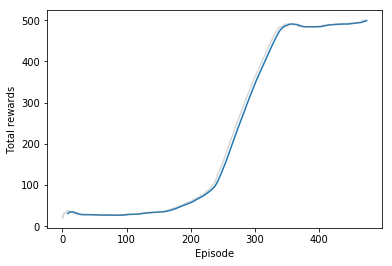

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

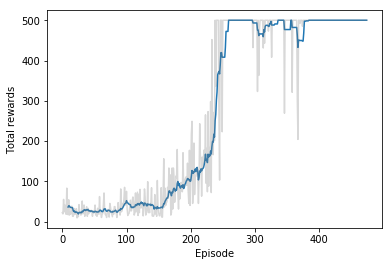

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

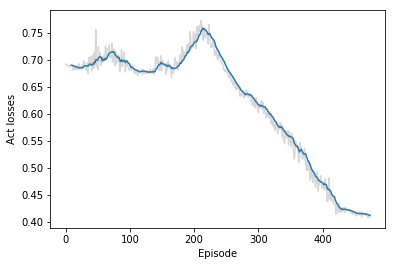

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

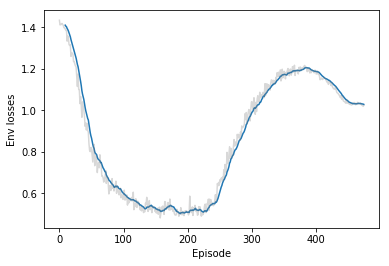

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

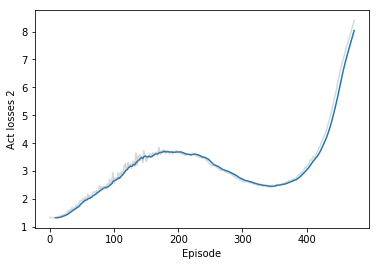

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
